In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/tviel/work/kaggle_rsna_lumbar_spine/src


/home/tviel/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import os
import re
import cv2
import json
import glob
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from collections import Counter
from tqdm.notebook import tqdm

pd.set_option('display.width', 500)
pd.set_option('max_colwidth', 100)

In [4]:
from params import *

from data.preparation import prepare_data

from util.plots import *
from util.logger import Config
from util.torch import load_model_weights

from model_zoo.models_seg import define_model

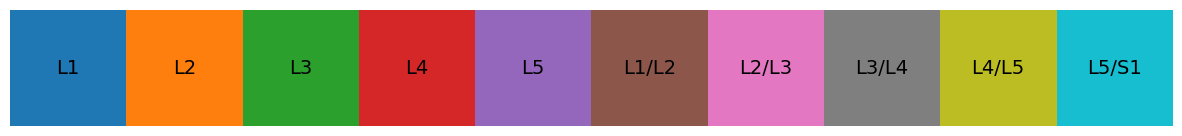

In [5]:
legend = np.arange(1, len(CLASSES_SEG) + 1)
plt.figure(figsize=(15, 5))
plt.imshow(legend[None],  cmap='tab10')
for i in range(len(CLASSES_SEG)):
    plt.text(i, 0, CLASSES_SEG[i], horizontalalignment='center', verticalalignment='center', fontsize=14)
plt.axis(False)
plt.show()

In [6]:
# dd = pd.read_csv(DATA_PATH + "train_label_coordinates.csv")
# dd[(dd['x'] < 20) | (dd['y'] < 20)]  #.series_id.values
# dd[dd["series_id"]== 880361156]

In [7]:
DEVICE = "cuda:0"
# DEVICE = "cpu"

In [8]:
# EXP_FOLDER = "../logs/2024-07-31/6/"
# EXP_FOLDER = "../logs/2024-07-31/15/"
EXP_FOLDER = "../logs/2024-07-31/20/"  
# EXP_FOLDER = "../logs/2024-07-31/21/"
# EXP_FOLDER = "../logs/2024-07-31/22/"
EXP_FOLDER = "../logs/2024-07-31/25/"  # <--- BEST

In [9]:
EXP_FOLDERS = [
    # "../logs/2024-07-31/20/",
    # "../logs/2024-07-31/22/",
    "../logs/2024-07-31/25/"
]

In [10]:
models = []
for exp_folder in EXP_FOLDERS:

    config = Config(json.load(open(exp_folder + "config.json", "r")))

    model = define_model(
        config.decoder_name,
        config.name,
        num_classes=config.num_classes,
        num_classes_aux=config.num_classes_aux,
        increase_stride=config.increase_stride,
        use_cls=config.use_cls,
        n_channels=config.n_channels,
        use_3d=config.use_3d,
        verbose=(config.local_rank == 0),
    ).to(DEVICE)
    # model = model.eval()

    fold = 0
    model = load_model_weights(model, exp_folder + f"{config.name}_{fold}.pt")
    models.append(model)


 -> Loading encoder weights from ../logs/2024-07-31/25/resnet34d_0.pt



### Inference comp data


In [11]:
df = prepare_data(DATA_PATH)

In [12]:
PLOT = True
SAVE = False

In [13]:
def get_coords(pred):

    starts, ends, mids = [], [], []
    for i in range(5, 10):
        w = (pred == (i + 1)).sum((1, 2))
        w = w / w.sum()
        w = np.where(w > 0.05, w, 0)

        start, end, mid = np.argmax(w > 0), len(w) - np.argmax(w[::-1] > 0) - 1, np.argmax(w)
        starts.append(start)
        ends.append(end)
        mids.append(mid)

    #     plt.plot(w, label=CLASSES_SEG[i])
    # plt.legend()
    # plt.show()

    start = int(np.percentile(starts, 80))
    end = int(np.percentile(ends, 20))
    mid = int(np.median(mids))

    return start, mid, end

  0%|          | 0/6294 [00:00<?, ?it/s]

- 4003253 - 702807833 - Sagittal T2/STIR
8 7


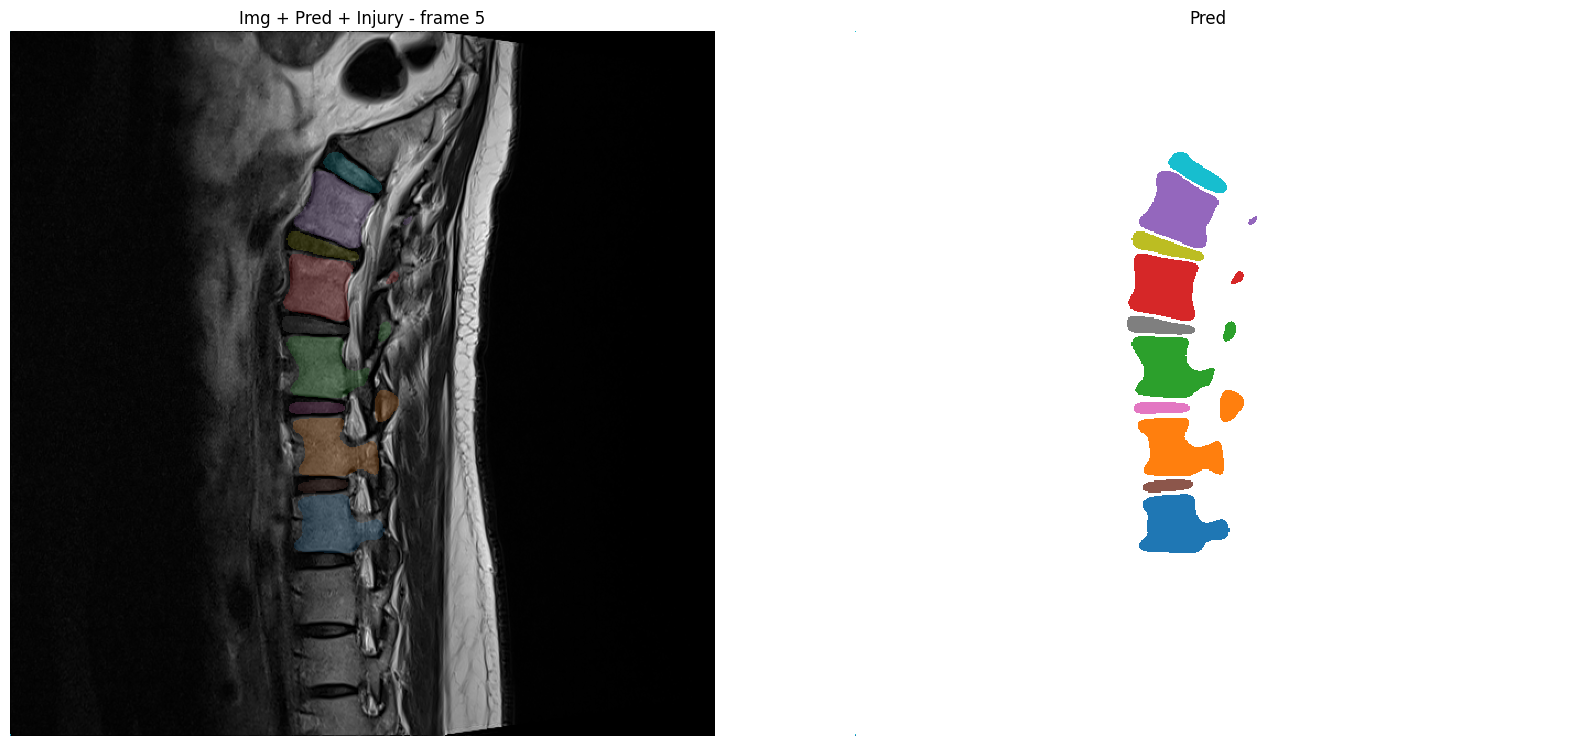

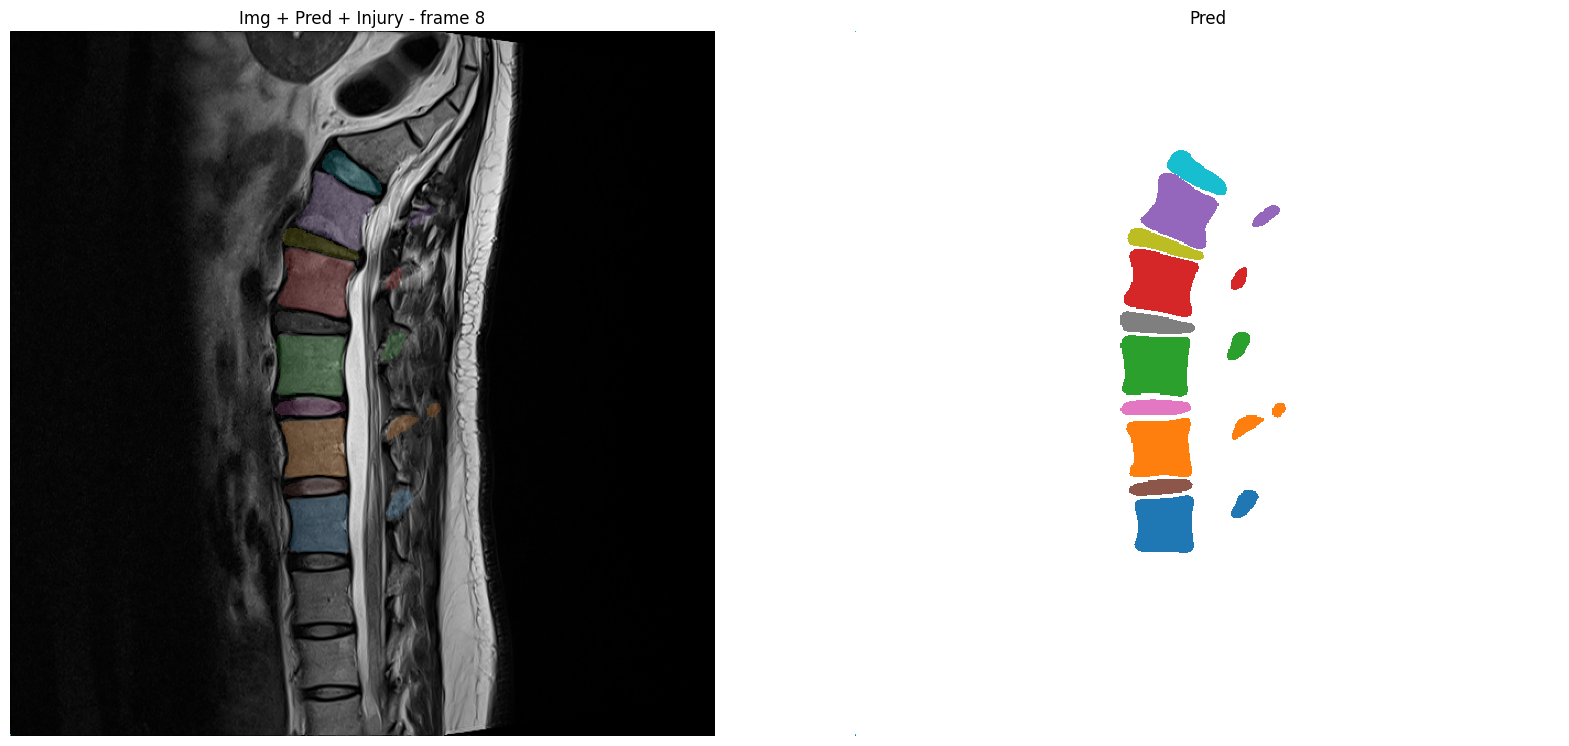

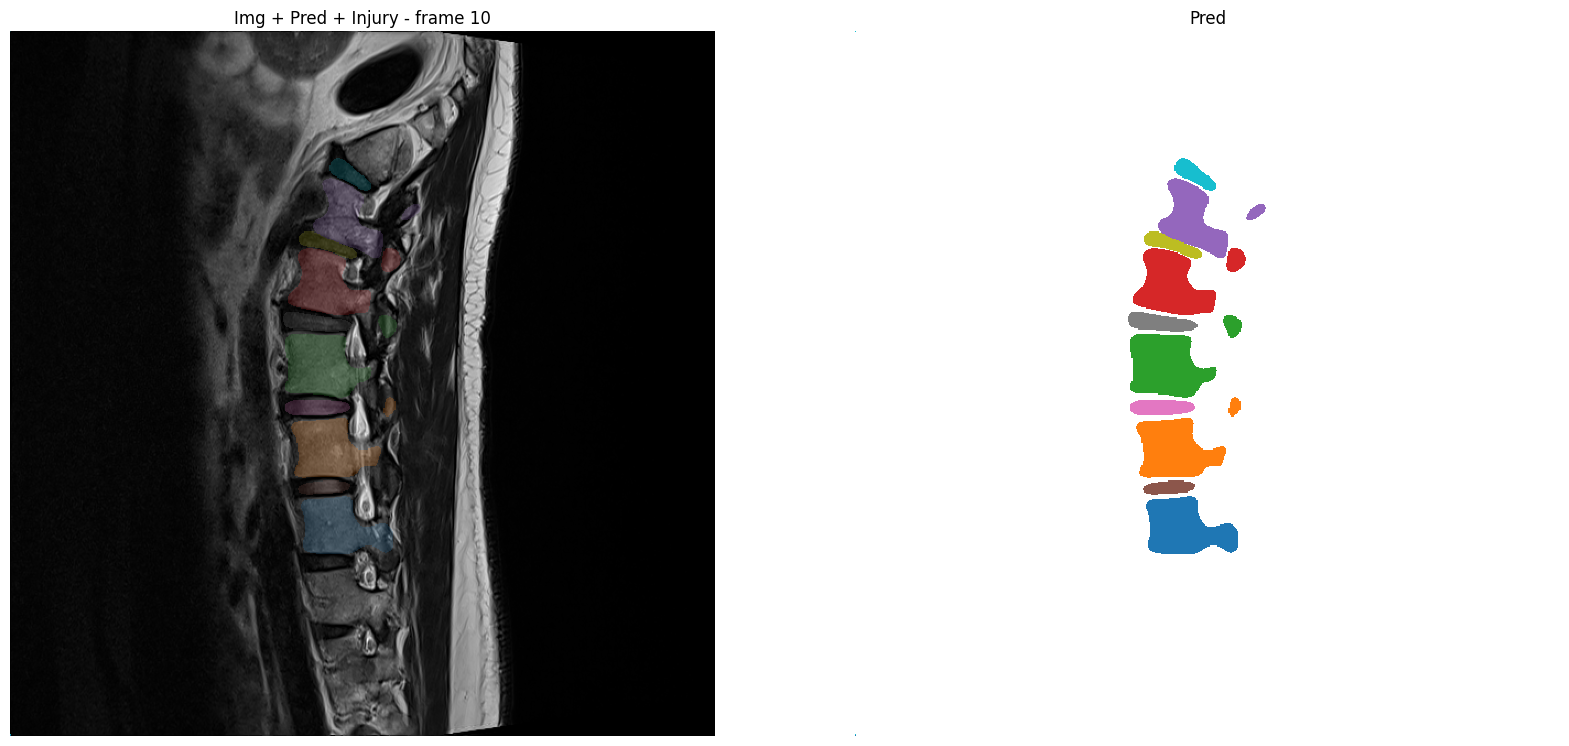

- 4003253 - 1054713880 - Sagittal T1
8 7


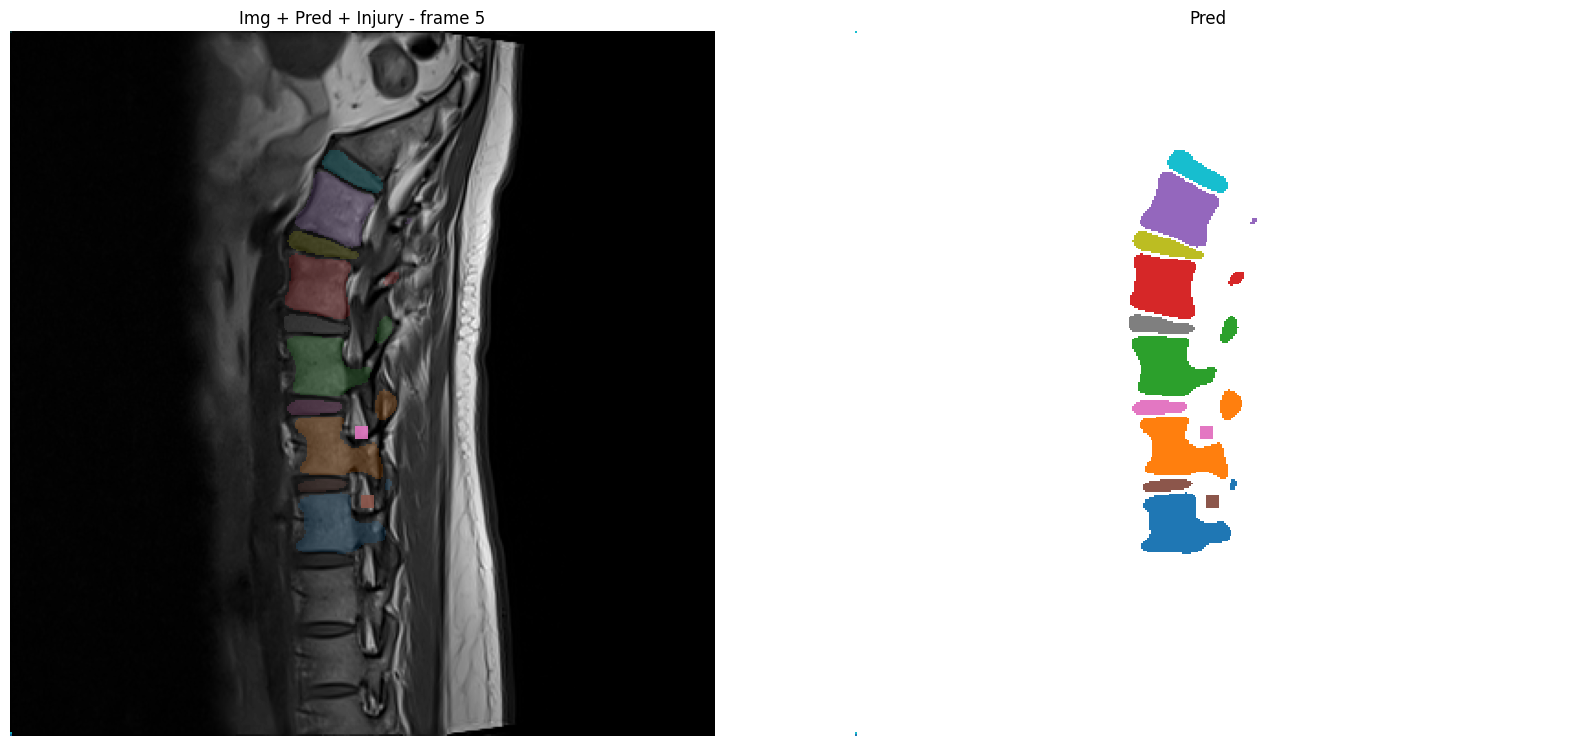

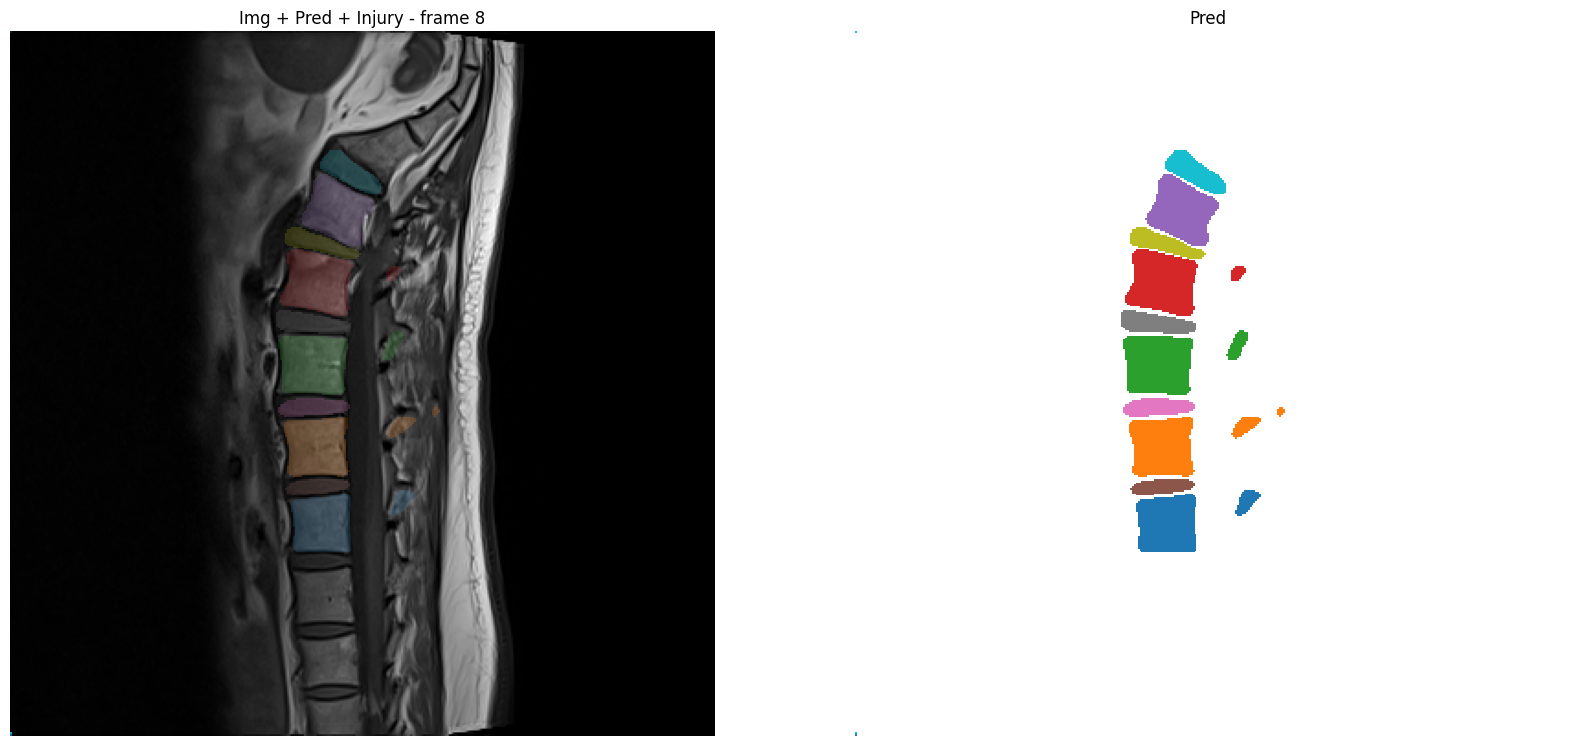

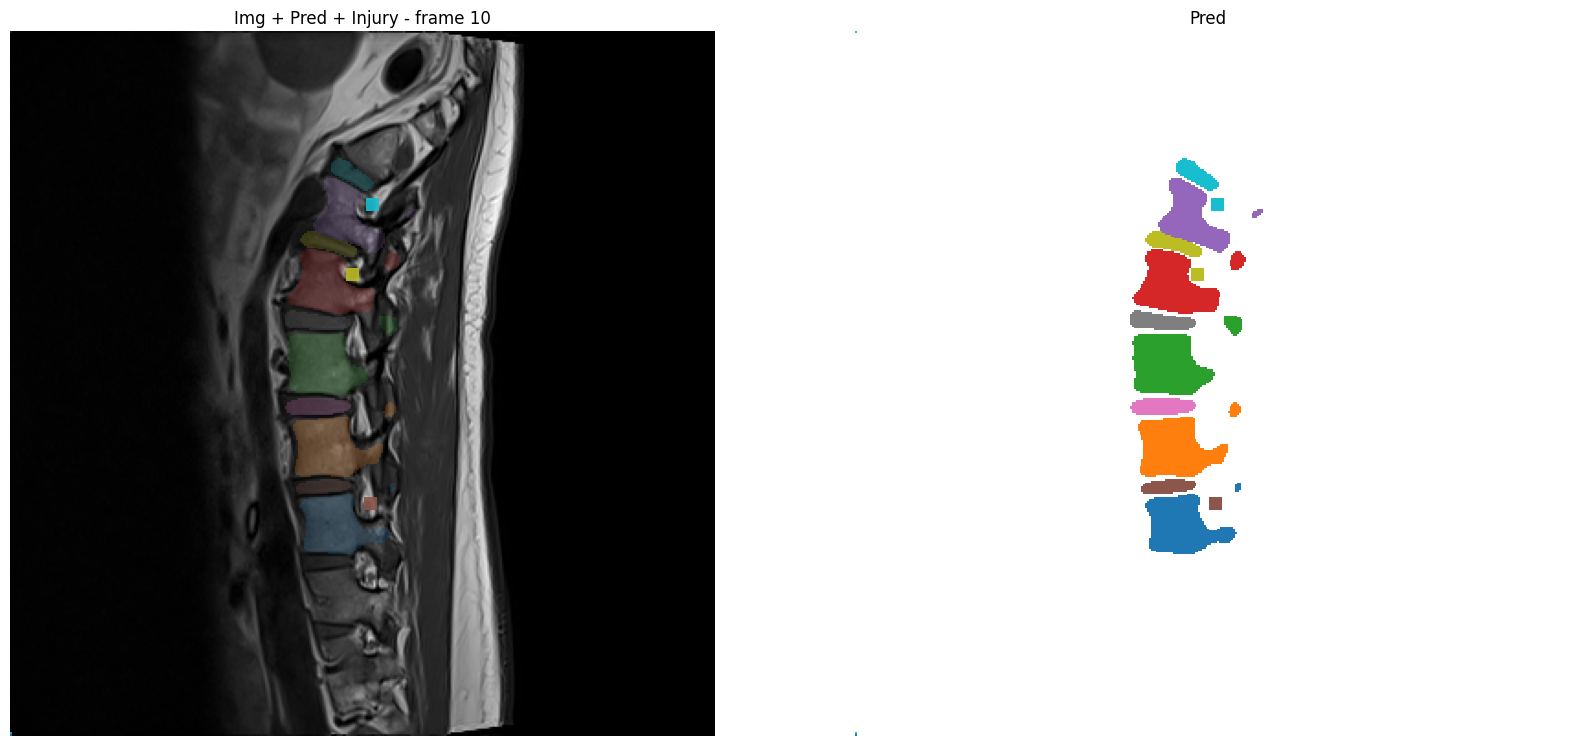

- 4003253 - 2448190387 - Axial T2
- 4646740 - 3201256954 - Axial T2
- 4646740 - 3486248476 - Sagittal T1
5 8


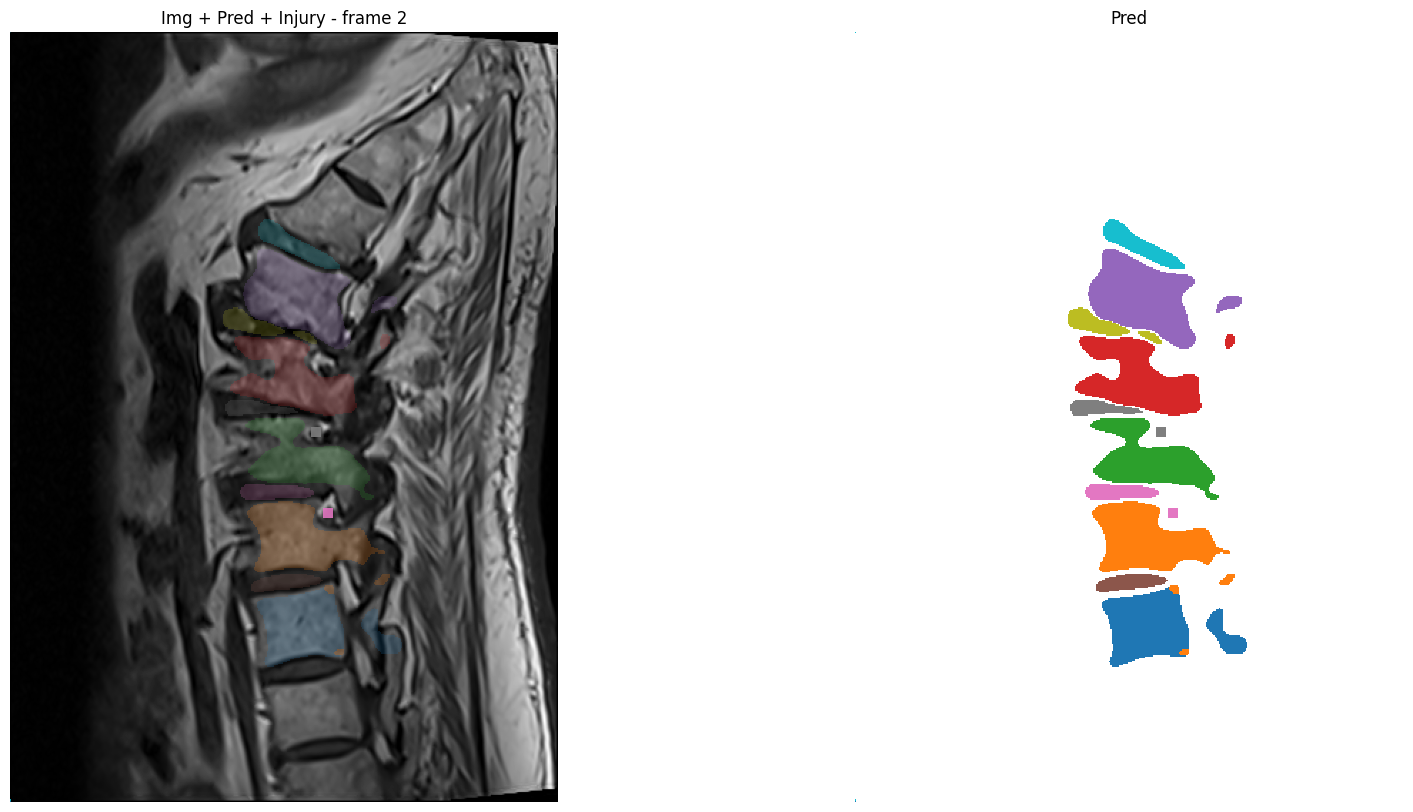

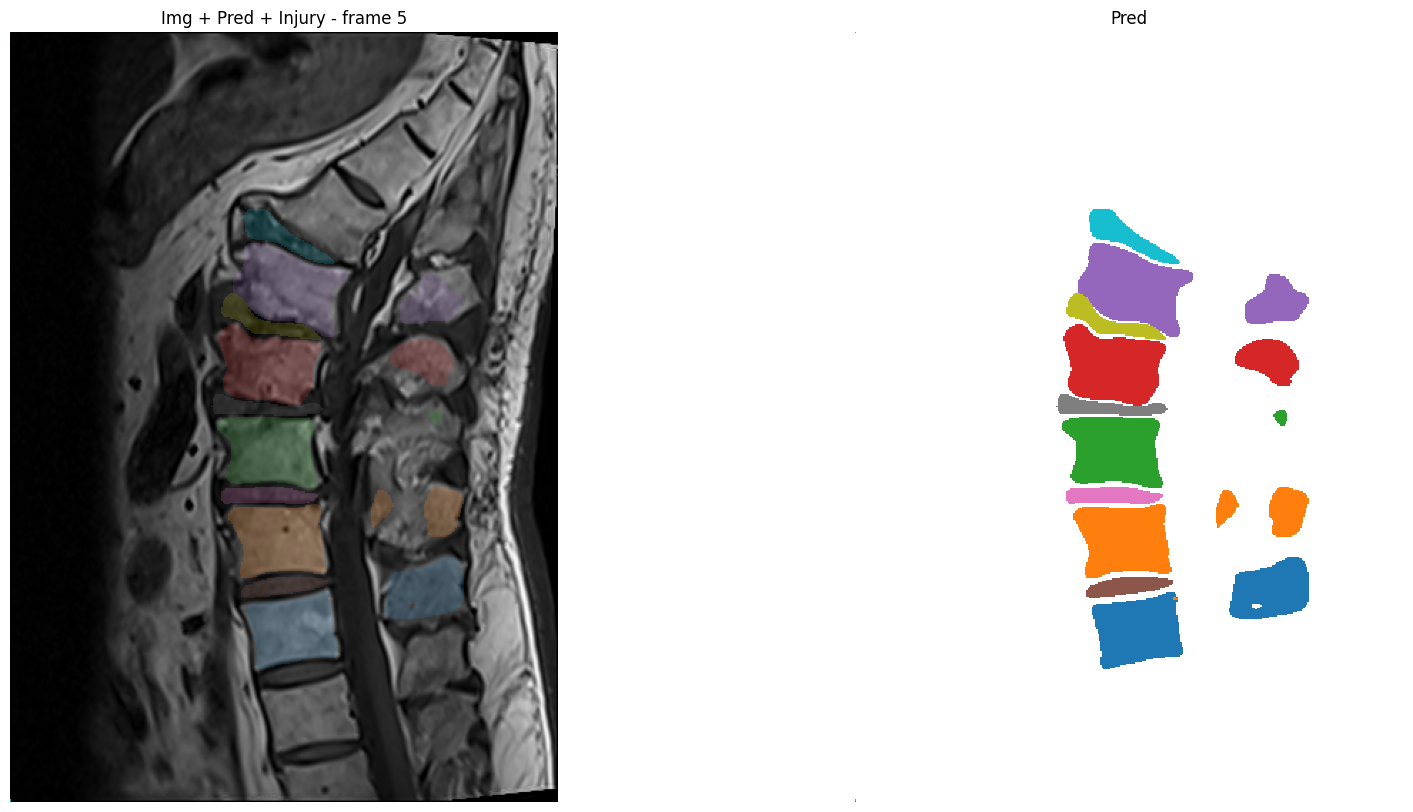

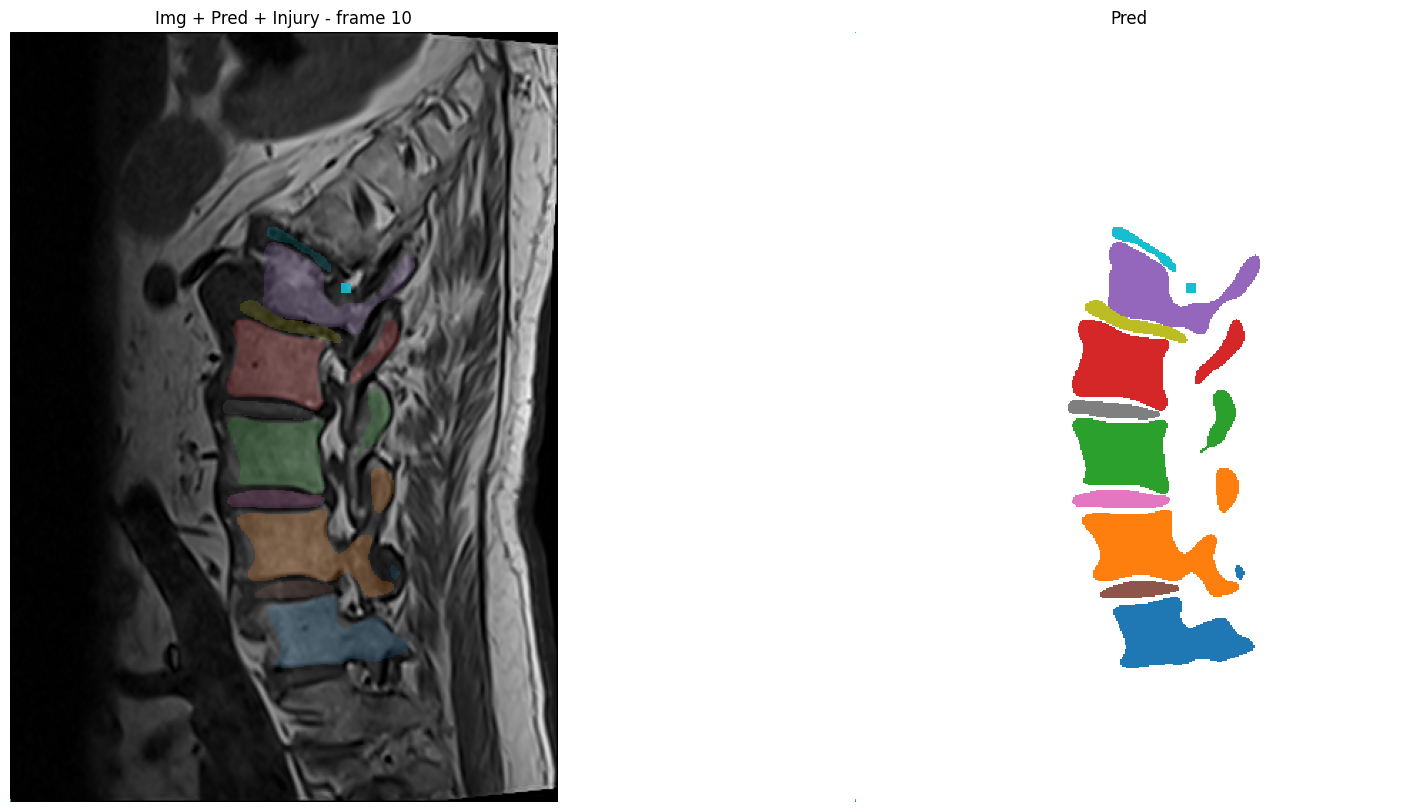

In [16]:
ious = []
pred_sag_coords = []
for idx in tqdm(range(0, len(df))):
    # if os.path.exists("../input/train_segs/" + df.img_path[idx].split("/")[-1]):
    #     continue
    img = np.load(df["img_path"][idx]).astype(np.float32)

    if PLOT:
        print(f'- {df.study_id[idx]} - {df.series_id[idx]} - {df.series_description[idx]}')
        try:
            injury_mask = get_injury_mask(img, df["coords"][idx], df["level"][idx])
        except:  # No injury
            continue

    if df['orient'][idx] == "Sagittal":
        img = img[:, ::-1].copy()
        injury_mask = injury_mask[:, ::-1]
    else:
        continue
        # img = img.transpose(2, 1, 0)

    with torch.inference_mode():
        x = torch.from_numpy(img).to(DEVICE)
        x = F.interpolate(
            x.unsqueeze(0).unsqueeze(0),
            config.img_size,
            mode="trilinear",
        )
        x = (x - x.min()) / (x.max() - x.min())

        preds = []
        for model in models:
            pred, _ = model(x)
            pred = F.interpolate(
                pred,
                img.shape,
                mode="trilinear",
            )

            preds.append(pred.softmax(1))
    pred = torch.cat(preds, 0).mean(0)
    pred = pred.argmax(0)
    pred = pred.cpu().numpy()

    start, mid, end = get_coords(pred)

    if SAVE:
        mask = pred.astype(np.uint8)[:, ::-1]
        np.save(
            "../input/train_segs/" + df.img_path[idx].split("/")[-1],
            mask.copy(),
        )

    pred_sag_coords.append({
        "study_id": df.study_id[idx],
        "series_id": df.series_id[idx],
        "left": end,
        "center": mid,
        "right": start,
    })

    if PLOT:
        pred[:, 0, 0] = 10

        # for f in range(len(img)):
        for f in [start, mid, end]:
            # if f in df["coords"][idx]:
            plt.figure(figsize=(20, 10))

            plt.subplot(1, 2, 1)
            plt.imshow(img[f], cmap="gray")
            plt.imshow(
                np.where(pred[f] > 0, pred[f], np.nan),
                cmap="tab10",
                interpolation="none",
                alpha=0.2,
            )
            plt.imshow(
                np.where(injury_mask[f] > 0, injury_mask[f], np.nan),
                cmap="tab10",
                interpolation="none",
                alpha=0.9,
            )

            plt.axis(False)
            plt.title(f"Img + Pred + Injury - frame {f}")

            # plt.subplot(1, 2, 1)
            # plt.imshow(img[f], cmap="gray")
            # plt.imshow(
            #     np.where(injury_mask[f] > 0, injury_mask[f], np.nan),
            #     cmap="tab10",
            #     interpolation="none",
            #     alpha=0.5,
            # )
            # plt.axis(False)
            # plt.title("Img + Pred")
            plt.subplot(1, 2, 2)
            plt.imshow(
                np.where((injury_mask[f] + pred[f]) > 0, injury_mask[f] + pred[f], np.nan),
                cmap="tab10",
                interpolation="none",
            )
            plt.axis(False)
            plt.title("Pred")

            plt.show()
        # break
    if PLOT:
        if idx >= 3:
            break


In [15]:
# df_preds_coords = pd.DataFrame(pred_sag_coords)
# df_preds_coords.to_csv('../output/seg_sag_coords.csv', index=False)
# df_preds_coords.head(3)

### Crops

In [ ]:
from inference.seg import get_crops
from util.plots import add_rect

In [ ]:
PLOT = True
SAVE = False

SAVE_FOLDER = "../input/crops_fix/"

if SAVE:
    os.makedirs(SAVE_FOLDER, exist_ok=True)

In [ ]:
from collections import defaultdict

cols = ["skyblue", "salmon", "lightgreen"]
col = cols[0]

In [ ]:
found_disks = []
injury_coords_in_crop_dict = {}

for idx in tqdm(range(0, len(df))):
    if df['orient'][idx] == "Axial":
        continue
    # if df['series_id'][idx] != 3951475160:
    #     continue
    if df['weighting'][idx] == "T2/STIR":
        continue

    print(f'- {df.study_id[idx]} - {df.series_id[idx]} - {df.series_description[idx]}')

    mask = np.load("../input/train_segs/" + df.img_path[idx].split("/")[-1])
    img = np.load(df["img_path"][idx]).astype(np.float32)

    try:
        injury_mask = get_injury_mask(img, df["coords"][idx], df["level"][idx])
    except:
        injury_mask = np.zeros_like(img).astype(np.uint8)

    disk_crops = {}
    frames_not_found = []
    found_dict = defaultdict(list)
    injury_coords_in_crop = defaultdict(list)
    
    for disk in CLASSES_SEG[5:]:
        x0, x1, y0, y1, z0, z1 = get_crops(mask, disk=disk)
        
        img_crop = img[x0: x1, y0:y1, z0:z1]
        mask_crop = mask[x0: x1, y0:y1, z0:z1]

        if SAVE:
            d = re.sub('/', '_', disk.lower())
            # print(df.img_path[idx].split("/")[-1][:-4] + f'_{d}.npy')
            np.save(SAVE_FOLDER + df.img_path[idx].split("/")[-1][:-4] + f'_{d}.npy', img_crop.copy())
            # break

        disk_crops[disk] = (x0, x1, y0, y1, z0, z1, img_crop, mask_crop)

        if isinstance(df['level'][idx], (list, np.ndarray)):
            for lvl, injury, coords in zip(df['level'][idx], df['condition'][idx], df['coords'][idx]):
                side = injury.split()[0]
                side = side if side in ["Left", "Right"] else ""
                if disk == lvl:
                    found = True
                    if coords[1] > 20 and coords[2] > 20:
                        found = (
                            x0 <= coords[0] and x1 >= coords[0] and
                            y0 < coords[2] and y1 > coords[2] and
                            z0 < coords[1] and z1 > coords[1]
                        )
                    if found:
                        injury_coords_in_crop[disk + "_" + side].append(
                            list(map(int, [coords[0] - x0, coords[1] - z0, coords[2] - y0]))
                        )
                    else:
                        injury_coords_in_crop[disk + "_" + side].append([-1, -1, -1])

                    if not found:
                        frames_not_found.append(int(coords[0]))
                        # print(df['study_id'][idx], df["series_id"][idx])
                        # print(lvl, coords, (x0, x1, y0, y1, z0, z1))

                    found_dict[disk].append(found)
        injury_coords_in_crop_dict[df.img_path[idx].split("/")[-1]] = injury_coords_in_crop

    for disk in CLASSES_SEG[5:]:
        found_dict[disk] = np.mean(found_dict[disk]) if len(found_dict[disk]) else 1
    found_disks.append(found_dict)
    # break

    if PLOT and np.min(list(found_dict.values())) <= 1:
        mask[:, 0, 0] = 10
        mask[:, 1, 0] = 1

        for f in np.unique(frames_not_found):
        # for f in np.unique(sorted(df["coords"][idx][:, 0].astype(int))):
            plt.figure(figsize=(15, 10))

            plt.subplot(1, 2, 1)
            plt.imshow(img[f], cmap="gray")
            plt.imshow(
                np.where(mask[f] > 0, mask[f], np.nan),
                cmap="tab10",
                interpolation="none",
                alpha=0.2,
            )
            plt.imshow(
                np.where(injury_mask[f] > 0, injury_mask[f], np.nan),
                cmap="tab10",
                interpolation="none",
                alpha=0.9,
            )
            for d, disk in enumerate(df['level'][idx]):
                (x0, x1, y0, y1, z0, z1, img_crop, mask_crop) = disk_crops[disk]
                add_rect(x0, x1, y0, y1, z0, z1, f, col="skyblue")

                plt.text(10, (d + 1) * 20, f'{disk} disk center frame: {int((x1 + x0) / 2)}', color="skyblue")
            plt.axis(False)
            plt.title("Img + Mask + Injury + Crop Bbox")

            plt.subplot(1, 2, 2)
            plt.imshow(
                np.where(injury_mask[f] > 0, injury_mask[f], np.nan),
                cmap="tab10",
                interpolation="none",
            )
            for disk in df['level'][idx]:
                (x0, x1, y0, y1, z0, z1, img_crop, mask_crop) = disk_crops[disk]
                add_rect(x0, x1, y0, y1, z0, z1, f, col="skyblue")
            plt.axis(False)
            plt.title(f"Injury + Crop bbox - Frame {f}")

            plt.show()

    if idx >= 1000 and PLOT:
        break

In [ ]:
pd.DataFrame(injury_coords_in_crop_dict).T.reset_index().head()

In [ ]:
df_injury_coords = pd.DataFrame(injury_coords_in_crop_dict).T.reset_index()

dfs = []
for level in df_injury_coords.columns[1:]:
    df_level = df_injury_coords[['index', level]].dropna()
    df_level = df_level.rename(columns={level: "coords_crop"})
    df_level['level'] = level.split('_')[0]
    df_level["side"] = level.split('_')[1]
    dfs.append(df_level)
df_injury_coords = pd.concat(dfs, ignore_index=True)

df_injury_coords["study_id"] = df_injury_coords["index"].apply(lambda x: x.split('_')[0])
df_injury_coords["series_id"] = df_injury_coords["index"].apply(lambda x: x.split('_')[1][:-4])
df_injury_coords = df_injury_coords[["study_id", "series_id", "level", "side", "coords_crop"]]
df_injury_coords = df_injury_coords.sort_values(["study_id", "series_id", "side", "level"]).reset_index(drop=True)

if SAVE:
    df_injury_coords.to_csv(SAVE_FOLDER + "df_injury_coords.csv", index=False)

df_injury_coords.head(30)

In [ ]:
pd.DataFrame(pd.DataFrame(found_disks).mean()).T

Done ! 